# Neural Network from Scratch

## Basic Introduction

* Neural network is a mathematical function that is used to approximate non-linear behaviour.
* each neuron typically receives linear combination of previous layer cell's output.
* And on current neuron, the output is passed through the activation function. **This induces the non-linear behavior**.
* THE REAL GAME IS OF WEIGHTS and BIASES.
* And, the weights are calculated using either backpropagation or empirical risk minimization.

<img src = https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Neural_network_example.svg/800px-Neural_network_example.svg.png width = "250" height = "400" >

**General steps to train neural network,**
1. Initialize parameters
2. forward pass
3. calculate loss
4. backward pass
5. update the parameters and reiterate ...

## Let's develop 5 layer feed forward neural network

### Import necessary libraries

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Defining model architecture

In [23]:
NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},    # Input layer
    {"input_dim": 25, "output_dim": 50, "activation": "relu"},   # hidden layer 1
    {"input_dim": 50, "output_dim": 50, "activation": "relu"},   # hidden layer 2
    {"input_dim": 50, "output_dim": 25, "activation": "relu"},   # hidden layer 3
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"}, # output layer
]

### Calculate total parameters

- **Input Layer**
  - In Input layer, we get 2 inputs per each neuron. Total neurons in this layer are 25.
  - hence, total parameters = 25*2 + 25 = **75 paramaters**
- **Hidden Layer 1**
  - from previous layer i.e., input layer, we are getting 25 inputs per each neuron in hidden layer 1. Total neurons in this layer are 50.
  - hence, total parameters = 25*50 + 50 = **1300 parameters**
- **Hidden Layer 2**
  - from previous layer i.e., hidden layer 1, we are getting 50 inputs per each neuron in hidden layer 2. Total neurons in this layer are 50.
  - hence, total parameters = 50*50 + 50 = **2550 parameters**
- **Hidden Layer 3**
  - from previous layer i.e., hidden layer 2, we are getting 50 inputs per each neuron in hidden layer 3. Total neurons in this layer are 25.
  - hence, total parameters = 50*25 + 25 = **1275 parameters**
- **Output Layer**
  - from previous layer i.e., hidden layer 3, we are getting 25 inputs per each neuron in output layer. This layer only has 1 neuron.
  - hence, total parameters = 25*1 + 1 = **26 parameters**


> ***Hence, total parameters are 75 + 1300 + 2550 + 1275 + 26 = 5226***

### Initialize parameters

There can be various methods of optimally initializing weights depending on the activation function used,
* **He initialization (for ReLU)**
  * multiply the random initialization with, $$\sqrt\frac{2}{\text{size  of  previous  layer}}$$
* **Xavier initialization (for Tanh)**
  * 2 is replaced with 1, $$\sqrt\frac{1}{\text{size  of  previous  layer}}$$
* **Glorot activation (for Tanh)**
  * multiplier is, $$\sqrt\frac{2}{\text{size of previous layer + size of current layer}}$$ 

In [24]:
def init_layers(nn_architecture, seed = 99):
    # random seed initiation
    np.random.seed(seed)
    
    # number of layers in our neural network
    number_of_layers = len(nn_architecture)
    # parameters storage initiation
    params_values = {}
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        
        # extracting the number of units in layers
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        # initiating the values of the W matrix
        # and vector b for subsequent layers
        params_values['W' + str(layer_idx)] = np.random.randn(layer_output_size, layer_input_size) * 0.1 #Dimenesion of the Weight: (layer_output_size, layer_input_size)
        params_values['b' + str(layer_idx)] = np.random.randn(layer_output_size, 1) * 0.1 # Dimenesion of the Bias: (layer_output_size, 1)
        
    return params_values

### Define activation functions for forward pass

> Activation functions are important to bring in non-linearity and develop complex relationships between inputs and the output.

<img src = https://www.researchgate.net/publication/341543950/figure/fig7/AS:893609914163202@1590064614215/Activation-functions-a-sigmoid-b-Tanh-c-ReLU-and-d-Leaky-ReLU.png width = "600" height = "400" >

#### Ever wondered how sigmoid and its derivative look like ???

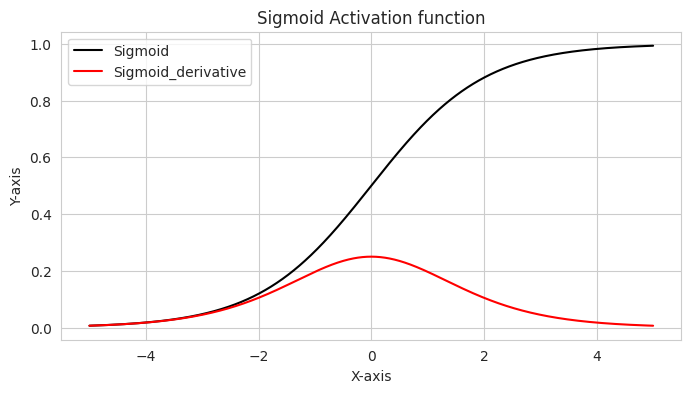

In [25]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def d_sigmoid(x):
    return sigmoid(x) * (1-sigmoid(x))

x = np.linspace(-5,5,1000)
plt.figure(figsize=(8, 4))
plt.plot(x, sigmoid(x), color='black', label='Sigmoid')
plt.plot(x, d_sigmoid(x), color='red', label='Sigmoid_derivative')
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Sigmoid Activation function")
plt.legend()
plt.show()

#### How about the tanh function ???

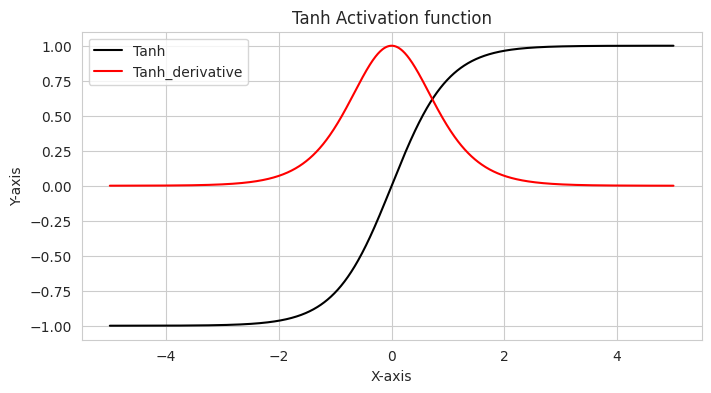

In [26]:
def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

def d_tanh(x):
    return 1-(tanh(x))**2

x = np.linspace(-5,5,1000)
plt.figure(figsize=(8, 4))
plt.plot(x, tanh(x), color='black', label='Tanh')
plt.plot(x, d_tanh(x), color='red', label='Tanh_derivative')
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Tanh Activation function")
plt.legend()
plt.show()

#### and the ReLU

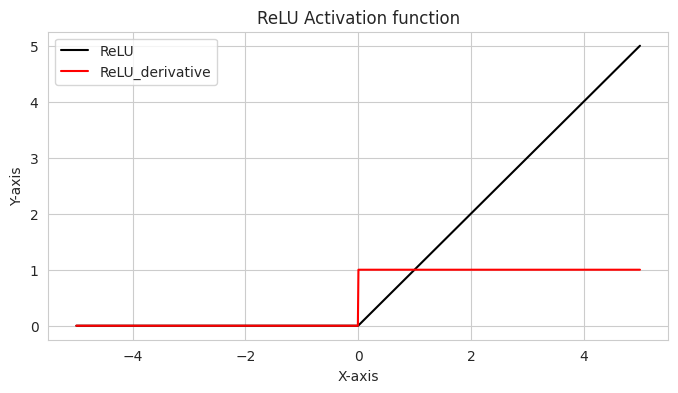

In [27]:
def relu(x):
    return x*(x>0)

def d_relu(x):
    return (x>0)*np.ones(x.shape)

x = np.linspace(-5,5,1000)
plt.figure(figsize=(8, 4))
plt.plot(x, relu(x), color='black', label='ReLU')
plt.plot(x, d_relu(x), color='red', label='ReLU_derivative')
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("ReLU Activation function")
plt.legend()
plt.show()

#### Now getting back to our code ...

In [28]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))
    
# relu activation function for the hidden layers of the network
def relu(Z):
    return np.maximum(0,Z)

### Forward Propagation

Some key points to remember,
* each neuron in previous layer (l-1) gives output denoted by $z_{l-1}$.
* But, when this output reaches neuron of next layer, activation function (f) is applied on it. Hence, next layer i.e., current layer (l) will see this incoming value as $f_{l-1}(z_{l-1})$, which can be denoted by $a_{l-1}$.
* Hence, $$z_l = a_{l-1}*W_l + b_l^T$$

> Hence, forward pass calculates $A$ from $A_\text{prev}$ using $W$, $B$, and the activation function of the previous layer i.e., $f_{l-1}$.

#### Single Layer Forward Propagation

In [29]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    if activation == "relu":
        activation_func = relu
    elif activation == "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')

    return activation_func(Z_curr), Z_curr

#### Function for Forward Propagation

In [30]:
def full_forward_propagation(X, params_values, nn_architecture):
    #print("Forward Propagating ...")
    # creating a temporary memory to store the information needed for a backward step
    memory = {}
    # X vector is the activation for layer 0 
    A_curr = X 
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        #print("\n\tIn layer {}".format(str(idx+1)))
        layer_idx = idx + 1           # we number network layers from 1
        A_prev = A_curr               # transfer the activation
        
        activ_function_curr = layer["activation"]
        W_curr = params_values["W" + str(layer_idx)]
        b_curr = params_values["b" + str(layer_idx)]
        #print("\n\tW shape: {}, b shape: {}".format(W_curr.shape, b_curr.shape))
        
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, 
                                                          W_curr, 
                                                          b_curr, 
                                                          activ_function_curr)
        # saving calculated values in the memory
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
        #print("\n\t A, Z extracted and saved to memory.")
    return A_curr, memory

### Define cost function

* cost function measures error between preedicted and actual value, and is a function of weights and bias.
* As a result, optimizing for cost function also enables us to update weights and bias of our network.

In [31]:
''' binary cross-entropy loss '''
def get_cost_value(Y_hat, Y):
    m = Y_hat.shape[1]
    cost = -1 / m * (
        np.dot(Y, np.log(Y_hat).T) + 
        np.dot(1 - Y, np.log(1 - Y_hat).T)
    ) 
    
    return np.squeeze(cost)

In [32]:
''' Converting Probabilities into Classes '''
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

In [33]:
def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

### Backward Propagation

Some key points to remember,
* It's actually the method of injecting the errors made during forward pass, back into the network and recalculating the parameters i.e., weights and biases and thus, perform better in next iteration.
* For any layer, backpropagation error is partial derivative of cost function wrt weighted sum of that layer i.e., $$\delta_l = \frac{\partial J(W, b)}{\partial z_l}$$
* Let's see how it works,
  * **from forward propagation**, we got $$z_l = a_{l-1}*W_l + b_l^T$$
  * **cost function** is actually a function of actual and predictions and hence can be written as (considering $a_L$ is predictions and $y$ is the true value), $$\text{cost function} = J(a_L,y) = J(W, b)$$
  * **Output layer backpropagation error**, $$\delta_L = \frac{\partial J(W, b)}{z_L} = \frac{\partial J(W, b)}{\partial a_L} * \frac{\partial a_L}{\partial z_L}$$
    * since, $a_L = f_L(z_L)$, therefore, $$\delta_L = \frac{\partial J(W, b)}{z_L} = \frac{\partial J(W, b)}{\partial a_L} * f^{'}_L(z_L)$$
  * Now, **hidden layer backpropagation error**,
    * we know, $z_l = a_{l-1}*W_l + b_l^T$,and therefore, $z_{l+1} = a_{l}*W_{l+1} + b_{l+1}^T$
    * we had, $$\delta_L = \frac{\partial J(W, b)}{z_L} = \frac{\partial J(W, b)}{\partial a_L} * \frac{\partial a_L}{\partial z_L}$$
    * Using second previous bullet, $$\frac{\partial J(W, b)}{\partial a_l} = \frac{\partial J(W, b)}{\partial z_{l+1}} * \frac{\partial z_{l+1}}{\partial a_l}$$
    * Therefore, $$\frac{\partial J(W, b)}{\partial a_l} = \delta_{l+1} * W^T_{l+1}$$
  * Now, using output layer and hidden layer backpropagation final equations, we can say that, $$\delta_{l} = \delta_{l+1}W^T_{l+1} * f^{'}_l(z_l)$$
  * **Rate of change of cost wrt weights**, $$\frac{\partial J(W, b)}{\partial W_l} = \frac{\partial J(W, b)}{\partial z_l}*\frac{\partial z_l}{\partial W_l} = \delta_l*a^T_{l-1}$$
  * **Rate of change of cost wrt bias**, $$\frac{\partial J(W, b)}{\partial b_l} = \frac{\partial J(W, b)}{\partial z_l}*\frac{\partial z_l}{\partial b_l} = \delta_l$$

> * These gradients are used to update the weight and bias parameters.
> * Backward pass is all about calculating gradients, $dW$, $db$ and $dA_\text{prev}$.

#### One step Backward Propagation

**Terminologies**
* dZ_curr: derivative of the activation function
* dA_curr: Gradient of the loss w.r.t. the current layer's activation (from the next layer)
* W_curr, b_curr: Parameters of current layer
* Z_curr: Linear output before activation in current layer
* A_prev: Activation from previous layer

Let's see how the four equations will helps us in solving backpropagation,
* **Output layer backpropagation error**, $$\delta_L = \frac{\partial J(W, b)}{z_L} = \frac{\partial J(W, b)}{\partial a_L} * f^{'}_L(z_L)$$
* **Hidden layer backpropagation error**,$$\delta_{l} = \delta_{l+1}W^T_{l+1} * f^{'}_l(z_l)$$
* **Rate of change of cost wrt weights**, $$\frac{\partial J(W, b)}{\partial W_l} =  \delta_l*a^T_{l-1}$$
* **Rate of change of cost wrt bias**, $$\frac{\partial J(W, b)}{\partial b_l} = \delta_l$$


If we want to update weights of the 1st neuron of the last layer, we will have to calculate $$\frac{\delta C}{\delta w_{11}^4} = (\frac{\delta C}{\delta a^4})*(\frac{\delta a^4}{\delta z_{1}^4})*(\frac{\delta z_1^4}{\delta w_{11}^4})$$

In above RHS, 1st element is simply driven from the cost function, while the 2nd is nothing but the derivative of the cost function. The 3rd is activation of the third layer (previous layer). In this case, above equation will now look like, $$\frac{\delta C}{\delta w_{11}^4} = (2.(a_1^{'}-a_1^4))*(a_1^4.(1-a_1^4))*(a_1^3) = \delta_1^4*a_1^3$$ 
The above equation is nothing but eq (3) of the 4 equations of back propagation.
Also, if we want to update bias, above equation can be used
$$\frac{\delta C}{\delta b_{1}^4} = \delta_1^4$$ 

This means, as long as we know $\delta$ for any layer, we can calculate derivative of cost wrt the parameters for that layer.

In [34]:
# gradient calculation of sigmoid activations
def sigmoid_backward(dA, Z):
    return dA * sigmoid(Z) * (1 - sigmoid(Z))
    
# gradient calculations of relu activations
def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

In [35]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    # number of examples
    m = A_prev.shape[1]
    
    # selection of activation function
    if activation == "relu":
        backward_activation_func = relu_backward
    elif activation == "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    # calculation of the activation function derivative
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    
    # derivative of the matrix W
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    # derivative of the vector b
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    # derivative of the matrix A_prev
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

In [36]:
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    
    # number of examples
    m = Y.shape[1]
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)
    
    # initiation of gradient descent algorithm
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));

    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        # we number network layers from 1
        layer_idx_curr = layer_idx_prev + 1
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]

        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

### Defining function to update the parameters

* At each layer, the update happens in the following way,
  * at time t + 1,
    * $$w_{t+1} = w_t - \alpha * \frac{\delta J}{\delta w}$$
    * $$b_{t+1} = b_t - \alpha * \frac{\delta J}{\delta b}$$

In [37]:
def update(params_values, grads_values, nn_architecture, learning_rate):
    # iteration over network layers
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values;

### Training the Neural Network

In [38]:
def train(X, Y, nn_architecture, epochs, learning_rate, verbose=True, callback=None):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture, 2)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []

    for i in range(epochs):
        # step forward
        Y_hat, cashe = full_forward_propagation(X, params_values, nn_architecture)
        
        # calculating metrics and saving them in history
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)

        # step backward - calculating gradient
        grads_values = full_backward_propagation(Y_hat, Y, cashe, params_values, nn_architecture)
        # updating model state
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
        if(i % 50 == 0):
            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            if(callback is not None):
                callback(i, params_values)
            
    return params_values

## Making Dataset

In [39]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

N_SAMPLES = 1000
TEST_SIZE = 0.1

X, y = make_classification(N_SAMPLES, n_features=2, 
                           n_redundant=0, n_informative=1,
                           n_clusters_per_class=1, random_state=14)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=42)

In [40]:
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(15,6))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)

    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    plt.show()
    if(file_name):
        plt.savefig(file_name)
        plt.close()

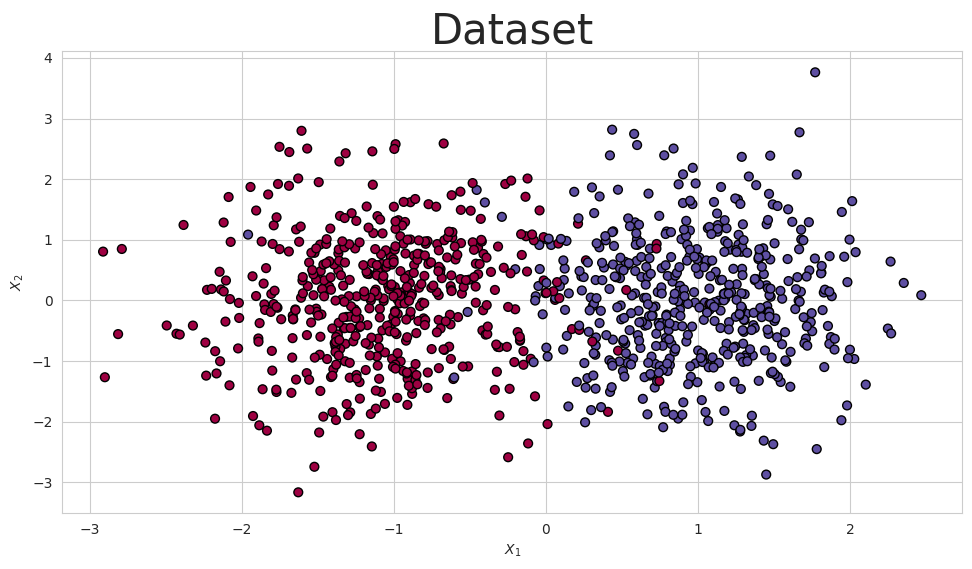

In [41]:
make_plot(X, y, "Dataset")

## Training and Testing the Neural Network

In [43]:
''' Training '''
params_values = train(np.transpose(X_train), 
                      np.transpose(y_train.reshape((y_train.shape[0], 1))), 
                      NN_ARCHITECTURE, 
                      10000, 
                      0.01)

Iteration: 00000 - cost: 0.69428 - accuracy: 0.49444
Iteration: 00050 - cost: 0.69405 - accuracy: 0.49444
Iteration: 00100 - cost: 0.69384 - accuracy: 0.49444
Iteration: 00150 - cost: 0.69365 - accuracy: 0.49444
Iteration: 00200 - cost: 0.69347 - accuracy: 0.49444
Iteration: 00250 - cost: 0.69330 - accuracy: 0.46000
Iteration: 00300 - cost: 0.69314 - accuracy: 0.50778
Iteration: 00350 - cost: 0.69299 - accuracy: 0.50556
Iteration: 00400 - cost: 0.69284 - accuracy: 0.50556
Iteration: 00450 - cost: 0.69269 - accuracy: 0.50556
Iteration: 00500 - cost: 0.69254 - accuracy: 0.50556
Iteration: 00550 - cost: 0.69239 - accuracy: 0.50556
Iteration: 00600 - cost: 0.69224 - accuracy: 0.50556
Iteration: 00650 - cost: 0.69209 - accuracy: 0.50556
Iteration: 00700 - cost: 0.69193 - accuracy: 0.50556
Iteration: 00750 - cost: 0.69177 - accuracy: 0.50556
Iteration: 00800 - cost: 0.69160 - accuracy: 0.50556
Iteration: 00850 - cost: 0.69142 - accuracy: 0.50556
Iteration: 00900 - cost: 0.69123 - accuracy: 0

In [44]:
params_values.keys()

dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4', 'W5', 'b5'])

In [45]:
params_values['W1'].shape, params_values['b1'].shape

((25, 2), (25, 1))

In [46]:
''' Testing '''
Y_test_hat_dW_dB = full_forward_propagation(np.transpose(X_test), 
                                            params_values, 
                                            NN_ARCHITECTURE)

In [47]:
acc_test = get_accuracy_value(Y_test_hat_dW_dB[0], 
                              np.transpose(y_test.reshape((y_test.shape[0], 1))))
print("Test set accuracy: {:.2f} ".format(acc_test))

Test set accuracy: 0.97 


## Some other key notes related to Neural Network

### Epoch and Batches

* 1 epoch is when an entire dataset is passed forward and backward once.
* when data is big, we operate in batches. So, if our entire dataset has been divided into 4 batches (for example), when these 4 batches have been passed through the network, we say 1 epoch is done.

### Parameters and Hyperparameters

* Parameters are elements that we learn through iterations, like W, b.
* Hyperparameters are elements that can be tuned in order to improve the model performance.